# CIS4930 -- Final Project
## Developed by: Chloe Fandino (Team Leader), Ashley James, Madelyne Wirbel, Chloe Nolan, Christopher Enlow

### Imports

In [1]:
# imports here :)

# TODO: DELETE ---> any imports that don't end up getting used by the end of the project !!!!

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

### Loading the data

In [2]:
df = pd.read_csv('OnlineNewsPopularity.csv') # import the data from the csv file --> convert to df

### Exploration of the dataset

In [3]:
# pd.set_option('display.max_rows', 100) # for purposes of looking at data --> need to see all rows

# basic intitial looks at the dataset
print(df.shape)

print(df.info())

(39644, 61)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords       

In [4]:
# Strip whitespace from column names
df.columns = df.columns.str.strip()

In [5]:
print(df.columns.tolist()) # print out all of the available columns

['url', 'timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', '

In [6]:
df.isnull().sum() # null values? --> NONE :)

url                             0
timedelta                       0
n_tokens_title                  0
n_tokens_content                0
n_unique_tokens                 0
                               ..
title_subjectivity              0
title_sentiment_polarity        0
abs_title_subjectivity          0
abs_title_sentiment_polarity    0
shares                          0
Length: 61, dtype: int64

In [7]:
df.duplicated().sum() # duplicate values? --> NONE :)

np.int64(0)

In [8]:
# check if any infinities exist in the dataframe
numeric_df = df.select_dtypes(include=[np.number])

has_inf = np.isinf(numeric_df.to_numpy()).any()

print(has_inf) # will need to handle in cleaning
inf_cols = numeric_df.columns[np.isinf(numeric_df.to_numpy()).any(axis=0)].tolist()
print("Columns with inf:", inf_cols)

False
Columns with inf: []


### Cleaning the data

Drop non-predictive columns

In [9]:
# exploration of potentially non-predictive features
df['url'].nunique() == len(df) # each example has a different url --> not needed in the dataset
df = df.drop(columns = ['url'])

df = df.drop(columns = ['timedelta']) # number of days since posted until added to the dataset --> no predictive qualities

Identify binary columns and ensure they are ints

In [10]:
binary_cols = [col for col in df.columns 
               if col.startswith("data_channel_is_") or col.startswith("weekday_is_")]

# ensure binary indicator columns are integers
df.columns = df.columns.str.strip()
print("Binary indicator columns:", binary_cols)

for col in binary_cols:
    df[col] = df[col].astype(int)

df[binary_cols].dtypes.head()

Binary indicator columns: ['data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday']


data_channel_is_lifestyle        int64
data_channel_is_entertainment    int64
data_channel_is_bus              int64
data_channel_is_socmed           int64
data_channel_is_tech             int64
dtype: object

Handle inf/NaN

In [11]:
# handling inf
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
print("Dataset shape after removing inf/NaN:", df.shape)

Dataset shape after removing inf/NaN: (39644, 59)


Remove highly correlated features

Text(0.5, 1.0, 'Correlation Heatmap')

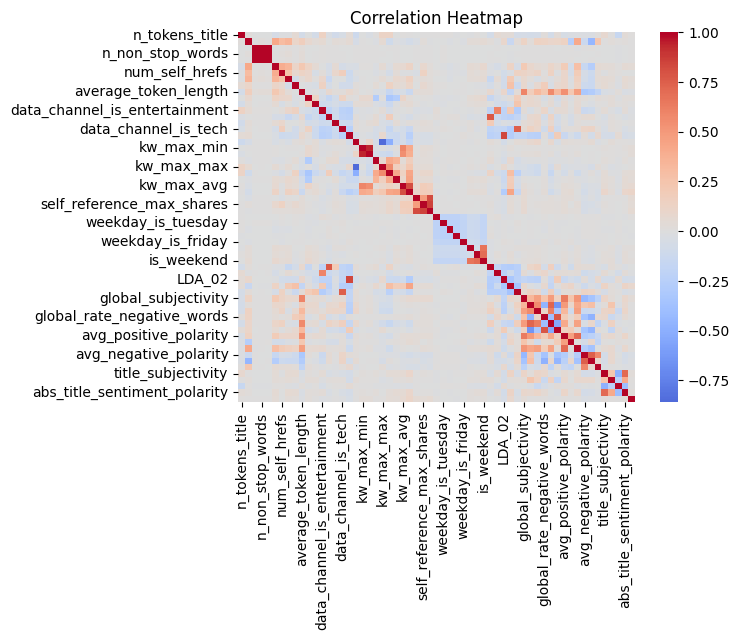

In [12]:
# test of feature correlation --> highly correlated features do not need to both be in dataser
df_correlation = df.corr()

sns.heatmap(df_correlation, cmap = 'coolwarm', center = 0)
plt.title("Correlation Heatmap")

In [13]:
X_corr = df.drop(columns=['shares'])
y_corr = df['shares']

def drop_correlated_by_importance(X, y, threshold=0.7, n_estimators=50, protected_cols=[]):
    model = ExtraTreesRegressor(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    model.fit(X, y)
    importances = pd.Series(model.feature_importances_, index=X.columns)

    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    corr_pairs = upper.stack().reset_index()
    corr_pairs.columns = ['feat1', 'feat2', 'corr']
    corr_pairs = corr_pairs[corr_pairs['corr'] > threshold]

    to_drop = set()
    for _, row in corr_pairs.iterrows():
        if row['feat1'] in protected_cols or row['feat2'] in protected_cols: # we dont want to drop binary indicator cols
            continue
        if importances[row['feat1']] >= importances[row['feat2']]:
            to_drop.add(row['feat2'])
        else:
            to_drop.add(row['feat1'])
    return list(to_drop)

In [14]:
columns_to_drop = drop_correlated_by_importance(
    X_corr, y_corr, threshold=0.6, n_estimators=50, protected_cols=binary_cols
)

print("Columns to drop due to high correlation:", columns_to_drop)
df = df.drop(columns=columns_to_drop)

Columns to drop due to high correlation: ['global_sentiment_polarity', 'global_rate_negative_words', 'kw_min_min', 'kw_max_avg', 'self_reference_min_shares', 'kw_avg_min', 'self_reference_avg_sharess', 'min_negative_polarity', 'rate_positive_words', 'avg_positive_polarity', 'n_non_stop_words', 'title_subjectivity', 'n_unique_tokens']


### Winsorization

In [15]:
# Identify numeric non-binary indicator columns
numeric_cols = [c for c in df.columns if c not in binary_cols + ['shares']]

# Winsorize
for col in numeric_cols:
    print(f"Before winsorizing {col}: min={df[col].min()}, max={df[col].max()}")
    df[col] = winsorize(df[col], limits=[0.01, 0.01])
    print(f"After winsorizing {col}: min={df[col].min()}, max={df[col].max()}\n")

Before winsorizing n_tokens_title: min=2.0, max=23.0
After winsorizing n_tokens_title: min=6.0, max=15.0

Before winsorizing n_tokens_content: min=0.0, max=8474.0
After winsorizing n_tokens_content: min=0.0, max=2257.0

Before winsorizing n_non_stop_unique_tokens: min=0.0, max=650.0
After winsorizing n_non_stop_unique_tokens: min=0.0, max=0.92105261946

Before winsorizing num_hrefs: min=0.0, max=304.0
After winsorizing num_hrefs: min=0.0, max=56.0

Before winsorizing num_self_hrefs: min=0.0, max=116.0
After winsorizing num_self_hrefs: min=0.0, max=20.0

Before winsorizing num_imgs: min=0.0, max=128.0
After winsorizing num_imgs: min=0.0, max=37.0

Before winsorizing num_videos: min=0.0, max=91.0
After winsorizing num_videos: min=0.0, max=21.0

Before winsorizing average_token_length: min=0.0, max=8.04153354633
After winsorizing average_token_length: min=0.0, max=5.44528301887

Before winsorizing num_keywords: min=1.0, max=10.0
After winsorizing num_keywords: min=3.0, max=10.0

Before wi

In [16]:
# function with anomaly detection process --> first visualize, then calculate IQR

## Currently not used in the final cleaning process, but kept for potential future use ##

def anomaly_detection(feature):
    # first boxplot to see potential outliers
    sns.boxplot(x = df[feature], color = 'purple')
    plt.title(feature)
    plt.show()

    # second calculate outliers based on IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)

    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    anomalies = df[(df[feature] < lower) | (df[feature] > upper)]
    print('Anomalies: \n', anomalies) # prints a list of potential anomalies
    return

## Training and Testing

### Create Training Split

In [17]:
# separate features
y = df["shares"]
X = df.drop(columns = ["shares"])

print(y.value_counts())

print("X shape:", X.shape)
print("y shape:", y.shape)

shares
1100      2308
1200      2018
1300      1740
1400      1592
1500      1323
          ... 
200100       1
306          1
119100       1
52900        1
53000        1
Name: count, Length: 1454, dtype: int64
X shape: (39644, 45)
y shape: (39644,)


In [18]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)

Training set: (31715, 45)
Test set: (7929, 45)


Skewness before log-transform: 34.09480268085864
Skewness after log-transform: 1.0183365656855565


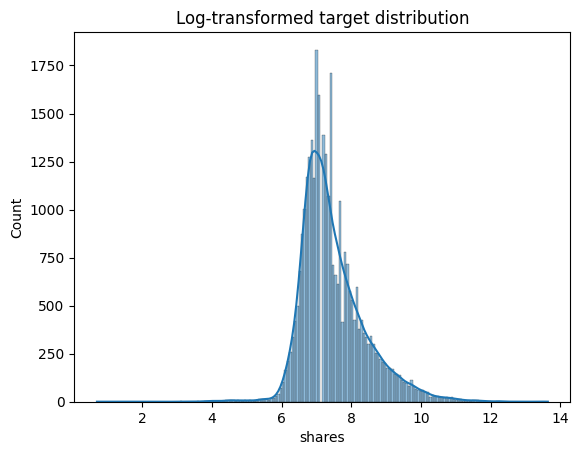

In [19]:
# scale the data
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Skewness before log-transform:", pd.Series(y_train).skew())

y_train_knn = y_train
y_test_knn = y_test
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

# Check skewness after log-transform
print("Skewness after log-transform:", pd.Series(y_train).skew())

sns.histplot(y_train, kde=True)
plt.title("Log-transformed target distribution")
plt.show()

### 1. Linear Regression Model

In [20]:
# train linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred = lin_reg.predict(X_test_scaled)

In [21]:
# evaluate linear regression performance

### 2. Neural Network

In [ ]:
# Convert features + targets to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # already log-scaled
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)   # already log-scaled

# DataLoaders
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor),
    batch_size=64,
    shuffle=False
)

# model definition
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

model = RegressionNN(input_dim=X_train_tensor.shape[1])

criterion = nn.MSELoss()  # MSE in log-space
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # slower lr for stability
n_epochs = 300

train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model.train()
    running_train_loss = 0.0

    # training step
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * X_batch.size(0)

    train_epoch_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(train_epoch_loss)

    # test step
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            test_loss = criterion(y_pred, y_batch)
            running_test_loss += test_loss.item() * X_batch.size(0)

    test_epoch_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(test_epoch_loss)

    # print every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}] "
              f"Train Loss: {train_epoch_loss:.4f} | "
              f"Test Loss: {test_epoch_loss:.4f}")

# plot loss curves
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss (log-space)")
plt.plot(test_losses, label="Test Loss (log-space)")
plt.xlabel("Epoch")
plt.ylabel("MSE (log-space)")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()

# evaluation on original scale
model.eval()
with torch.no_grad():
    y_pred_log = model(X_test_tensor).numpy()
    y_pred = np.expm1(y_pred_log).reshape(-1)             # invert log
    y_true = np.expm1(y_test_tensor.numpy()).reshape(-1)   # invert log

print("\nFINAL RESULTS:")
print("Test MSE:", mean_squared_error(y_true, y_pred))
print("Test R2: ", r2_score(y_true, y_pred))
print("Test MAE:", mean_absolute_error(y_true, y_pred))

Epoch [20/300] Train Loss: 10.4812 | Test Loss: 3.9084
Epoch [40/300] Train Loss: 26.2434 | Test Loss: 2.8942


### 3. KNN

In [ ]:
k_values = range(1, 40)
mse_scores = []

print("Finding optimal K using 'distance' weights...")

for k in k_values:
    # CRITICAL: We use weights='distance' inside the loop too
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn.fit(X_train_scaled, y_train_knn.values.ravel())
    
    # Predict on test set
    pred = knn.predict(X_test_scaled)
    
    # Calculate MSE (on raw values now)
    mse = mean_squared_error(y_test.values, pred)
    mse_scores.append(mse)

# Plot the Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(k_values, mse_scores, marker='o', linestyle='dashed')
plt.xlabel("K Value")
plt.ylabel("MSE (Lower is Better)")
plt.title("Finding Optimal K (Distance Weighted)")
plt.grid(True)
plt.show()

# Output the best K automatically
best_k = k_values[np.argmin(mse_scores)]
print(f"Best K found: {best_k}")

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 1. Define the model using the Best K found above
# weights='distance' is REQUIRED to predict high values in your dataset
knn_best = KNeighborsRegressor(n_neighbors=best_k, weights='distance')

# 2. Fit the model
knn_best.fit(X_train_scaled, y_train_knn.values.ravel()) 

# 3. Prediction (Directly in raw scale)
y_pred = knn_best.predict(X_test_scaled)
y_true = y_test_knn.values.ravel()

# 4. Evaluation
print(f"--- FINAL RESULTS (K={best_k}, Distance Weighted) ---")
print("Max Actual Value:   ", y_true.max())
print("Max Predicted Value:", y_pred.max()) # This should now be much closer to the max actual
print("-" * 30)
print("Test MSE:", mean_squared_error(y_true, y_pred))
print("Test R2: ", r2_score(y_true, y_pred))
print("Test MAE:", mean_absolute_error(y_true, y_pred))

In [ ]:
plt.figure(figsize=(10, 6))

# Scatter plot
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6, color='blue', edgecolor='k', label='Predictions')

# Perfect fit line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Perfect Fit')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"KNN Regression Results (k={best_k}): Predicted vs. Actual")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Choose which feature to visualize (0 is the first column)
feature_index = 0 
feature_name = "Feature 0" # Rename this to "Square Footage" or "Income" etc. if you know it

# Sort data for clean plotting
sort_idx = X_test_scaled[:, feature_index].argsort()
X_sorted = X_test_scaled[sort_idx]
y_pred_sorted = y_pred[sort_idx]
y_true_sorted = y_true[sort_idx]

plt.figure(figsize=(10, 6))

# 1. Plot the actual real data (Grey dots)
plt.scatter(X_sorted[:, feature_index], y_true_sorted, color='gray', alpha=0.4, label='Actual Data')

# 2. Plot the KNN prediction (Red line)
plt.plot(X_sorted[:, feature_index], y_pred_sorted, color='red', linewidth=2, label=f'KNN Prediction (k={best_k})')

plt.xlabel(f"Normalized {feature_name}")
plt.ylabel("Target Value")
plt.title(f"KNN Model Fit on {feature_name}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()